# Worksheet 6 - HA Two Heated Tanks

**Student:** Lucas de Oliveira Martim

In [105]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
import bisect as bi

def edInt(a, s, b):
    """Create evenly discretized interval from a to b with step s"""
    return np.linspace(a, b, int(np.floor((b-a)/s)) + 1)

def idx(aList, val):
    """Find nearest index in sorted list for given value"""
    i = bi.bisect(aList, val)  # right insertion point
    if i <= 0:  # val is before first element
        return 0
    elif i >= len(aList):  # val is after last element
        return len(aList) - 1
    elif val - aList[i-1] < aList[i] - val:  # closer to left
        return i - 1
    else:  # closer to right
        return i

def lookup(aList, vals):
    """Find nearest indices for values (nearest-neighbor interpolation)"""
    if isinstance(vals, (int, float, np.floating)):
        vals = [vals]
    return np.array([idx(aList, v) for v in vals], dtype=np.int32)

In [106]:
a1 = a2 = 0.01   # Heat loss coefficient
b1 = b2 = 0.005  # Coupling coefficient
h1 = h2 = 2.0    # Heater gain

t0, dt, tf = 0, 1, 200
T_time = edInt(t0, dt, tf)
N = T_time.size

x0 = np.array([15.0, 25.0])

infStValInc, nullCtr = 1e6, 0.0

T_MIN = 10   # Minimum temperature for both tanks
T_MAX = 60 # Maximum temperature for both tanks

dT = 0.5 # Temperature step for both tanks [C]

Q1_COST = Q2_COST = 10.0  # State cost weight for Tank
R1_COST = R2_COST = 1.0   # Control cost weight for Heater

U = edInt(0, 1, 1)
T = edInt(T_MIN, dT, T_MAX)

In [107]:
MODE_CTRL1 = 0  # Use SISO Controller 1 (focus on Tank 1)
MODE_CTRL2 = 1  # Use SISO Controller 2 (focus on Tank 2)

mode_names_c = {
    MODE_CTRL1: "Controller 1 (Tank 1)",
    MODE_CTRL2: "Controller 2 (Tank 2)"
}

epsilon_switch = 0.5  # Temperature tolerance in C

In [108]:
E_MIN = -50  # Minimum error (50°C below reference)
E_MAX = 50   # Maximum error (50°C above reference)
dE = 2       # Error discretization step

E = edInt(E_MIN, dE, E_MAX)  # Error grid


def solve_error_dp(tank_idx, Q_cost, R_cost):
    V = np.zeros((E.size, E.size, N))
    u_opt = np.zeros_like(V)
    
    # Terminal cost: just the error squared (reference-free!)
    E1_mesh, E2_mesh = np.meshgrid(E, E)
    if tank_idx == 0:
        V[:, :, N-1] = Q_cost * E1_mesh**2  # Penalize error in Tank 1
    else:
        V[:, :, N-1] = Q_cost * E2_mesh**2  # Penalize error in Tank 2
    
    inadmissible_count = 0
    
    # Backward DP in error coordinates
    for k in range(N-2, -1, -1):
        for i_e2 in range(E.size):
            for j_e1 in range(E.size):
                e1_curr = E[j_e1]  # Current error in Tank 1
                e2_curr = E[i_e2]  # Current error in Tank 2
                
                min_cost = float('inf')
                best_u = nullCtr
                
                for u_val in U:
                    if tank_idx == 0:
                        u1_val, u2_val = u_val, 0.0
                        e_controlled = e1_curr
                    else:
                        u1_val, u2_val = 0.0, u_val
                        e_controlled = e2_curr
                    
                    L = Q_cost * e_controlled**2 + R_cost * u_val**2
                    
                    e1_next = e1_curr + (-a1 * e1_curr + b1 * e2_curr + h1 * u1_val) * dt
                    e2_next = e2_curr + (b2 * e1_curr - a2 * e2_curr + h2 * u2_val) * dt
                    
                    # Check if error stays within bounds
                    if (e1_next >= E_MIN and e1_next <= E_MAX and 
                        e2_next >= E_MIN and e2_next <= E_MAX):
                        
                        j_e1_next = lookup(E, e1_next)[0]
                        i_e2_next = lookup(E, e2_next)[0]
                        
                        total_cost = L + V[i_e2_next, j_e1_next, k+1]
                        
                        if total_cost < min_cost:
                            min_cost = total_cost
                            best_u = u_val
                
                if min_cost == float('inf'):
                    V[i_e2, j_e1, k] = V[i_e2, j_e1, k+1] + infStValInc
                    inadmissible_count += 1
                else:
                    V[i_e2, j_e1, k] = min_cost
                
                u_opt[i_e2, j_e1, k] = best_u
    
    return V, u_opt, inadmissible_count

print("\nSolving for Controller 1 (Tank 1)...")
V_err_ctrl1, u_opt_err_ctrl1, inadm_ctrl1 = solve_error_dp(0, Q1_COST, R1_COST)
print(f"  Done! Inadmissible states: {inadm_ctrl1}")

print("\nSolving for Controller 2 (Tank 2)...")
V_err_ctrl2, u_opt_err_ctrl2, inadm_ctrl2 = solve_error_dp(1, Q2_COST, R2_COST)
print(f"  Done! Inadmissible states: {inadm_ctrl2}")

def get_control_from_error(e1, e2, k, controller_idx):
    e1_clamped = np.clip(e1, E_MIN, E_MAX)
    e2_clamped = np.clip(e2, E_MIN, E_MAX)
    
    # Find nearest grid indices
    j_e1 = lookup(E, e1_clamped)[0]
    i_e2 = lookup(E, e2_clamped)[0]
    
    if controller_idx == 0:
        return u_opt_err_ctrl1[i_e2, j_e1, k]
    else:
        return u_opt_err_ctrl2[i_e2, j_e1, k]


def simulate_ha_error_based(x0, x_ref_func, epsilon_switch=0.5):
    # Handle constant reference
    if callable(x_ref_func):
        get_ref = x_ref_func
    else:
        get_ref = lambda k: x_ref_func
    
    # Initialize
    x = np.zeros((N, 2))
    x[0, :] = x0
    u1_sim = np.zeros(N)
    u2_sim = np.zeros(N)
    mode_traj = np.zeros(N, dtype=int)
    ref_traj = np.zeros((N, 2))
    
    # Get initial reference and determine initial mode
    current_ref = get_ref(0)
    ref_traj[0] = current_ref
    
    e1_init = x0[0] - current_ref[0]
    e2_init = x0[1] - current_ref[1]
    
    if abs(e1_init) > abs(e2_init):
        current_mode = MODE_CTRL1
    else:
        current_mode = MODE_CTRL2
    
    mode_traj[0] = current_mode
    
    switch_count = 0
    
    for k in range(N-1):
        # Get current reference (can be time-varying!)
        current_ref = get_ref(k)
        ref_traj[k] = current_ref
        
        # Compute errors
        e1 = x[k, 0] - current_ref[0]
        e2 = x[k, 1] - current_ref[1]
        
        # Check for mode switching (with hysteresis)
        old_mode = current_mode
        if current_mode == MODE_CTRL1:
            if abs(e2) > abs(e1) + epsilon_switch:
                current_mode = MODE_CTRL2
        else:
            if abs(e1) > abs(e2) + epsilon_switch:
                current_mode = MODE_CTRL1
        
        if current_mode != old_mode:
            switch_count += 1
        
        mode_traj[k] = current_mode
        
        # Get optimal control from ERROR-BASED DP tables
        if current_mode == MODE_CTRL1:
            u1_sim[k] = get_control_from_error(e1, e2, k, 0)
            u2_sim[k] = 0.0
        else:
            u1_sim[k] = 0.0
            u2_sim[k] = get_control_from_error(e1, e2, k, 1)
        
        # Propagate actual dynamics (in absolute coordinates)
        x[k+1, 0] = x[k, 0] + (-a1 * x[k, 0] + b1 * x[k, 1] + h1 * u1_sim[k]) * dt
        x[k+1, 1] = x[k, 1] + (b2 * x[k, 0] - a2 * x[k, 1] + h2 * u2_sim[k]) * dt
    
    # Final values
    mode_traj[-1] = current_mode
    ref_traj[-1] = get_ref(N-1)
    
    return x, u1_sim, u2_sim, mode_traj, ref_traj





Solving for Controller 1 (Tank 1)...
  Done! Inadmissible states: 0

Solving for Controller 2 (Tank 2)...
  Done! Inadmissible states: 0


## Hybrid Automaton Simulation

Simulate the system with mode switching based on error magnitudes.

In [109]:
# Run simulation using error-based DP
print(f"Starting hybrid automaton simulation with ERROR-BASED DP...")
print(f"Initial state: T1={x0[0]:.2f}°C, T2={x0[1]:.2f}°C")
print(f"Reference:     T1={x_ref[0]:.2f}°C, T2={x_ref[1]:.2f}°C")

# Compute initial errors
error_T1_init = abs(x0[0] - x_ref[0])
error_T2_init = abs(x0[1] - x_ref[1])
print(f"Initial errors: e1={error_T1_init:.2f}°C, e2={error_T2_init:.2f}°C")

if error_T1_init > error_T2_init:
    print(f"Starting in mode: {mode_names_c[MODE_CTRL1]}")
else:
    print(f"Starting in mode: {mode_names_c[MODE_CTRL2]}")

# Run the error-based simulation
x_c, u1_sim_c, u2_sim_c, mode_traj_c, ref_traj_c = simulate_ha_error_based(
    x0, x_ref, epsilon_switch=epsilon_switch
)

# Count mode switches
mode_switches_c = np.sum(mode_traj_c[1:] != mode_traj_c[:-1])

print(f"\nSimulation complete!")
print(f"Final state: T1={x_c[-1,0]:.2f}°C, T2={x_c[-1,1]:.2f}°C")
print(f"Reference:   T1={x_ref[0]:.2f}°C, T2={x_ref[1]:.2f}°C")
print(f"Final error: e1={x_c[-1,0]-x_ref[0]:.2f}°C, e2={x_c[-1,1]-x_ref[1]:.2f}°C")
print(f"Mode switches: {mode_switches_c}")

Starting hybrid automaton simulation with ERROR-BASED DP...
Initial state: T1=15.00°C, T2=25.00°C
Reference:     T1=25.00°C, T2=30.00°C
Initial errors: e1=10.00°C, e2=5.00°C
Starting in mode: Controller 1 (Tank 1)

Simulation complete!
Final state: T1=25.27°C, T2=30.47°C
Reference:   T1=25.00°C, T2=30.00°C
Final error: e1=0.27°C, e2=0.47°C
Mode switches: 23


## Visualization

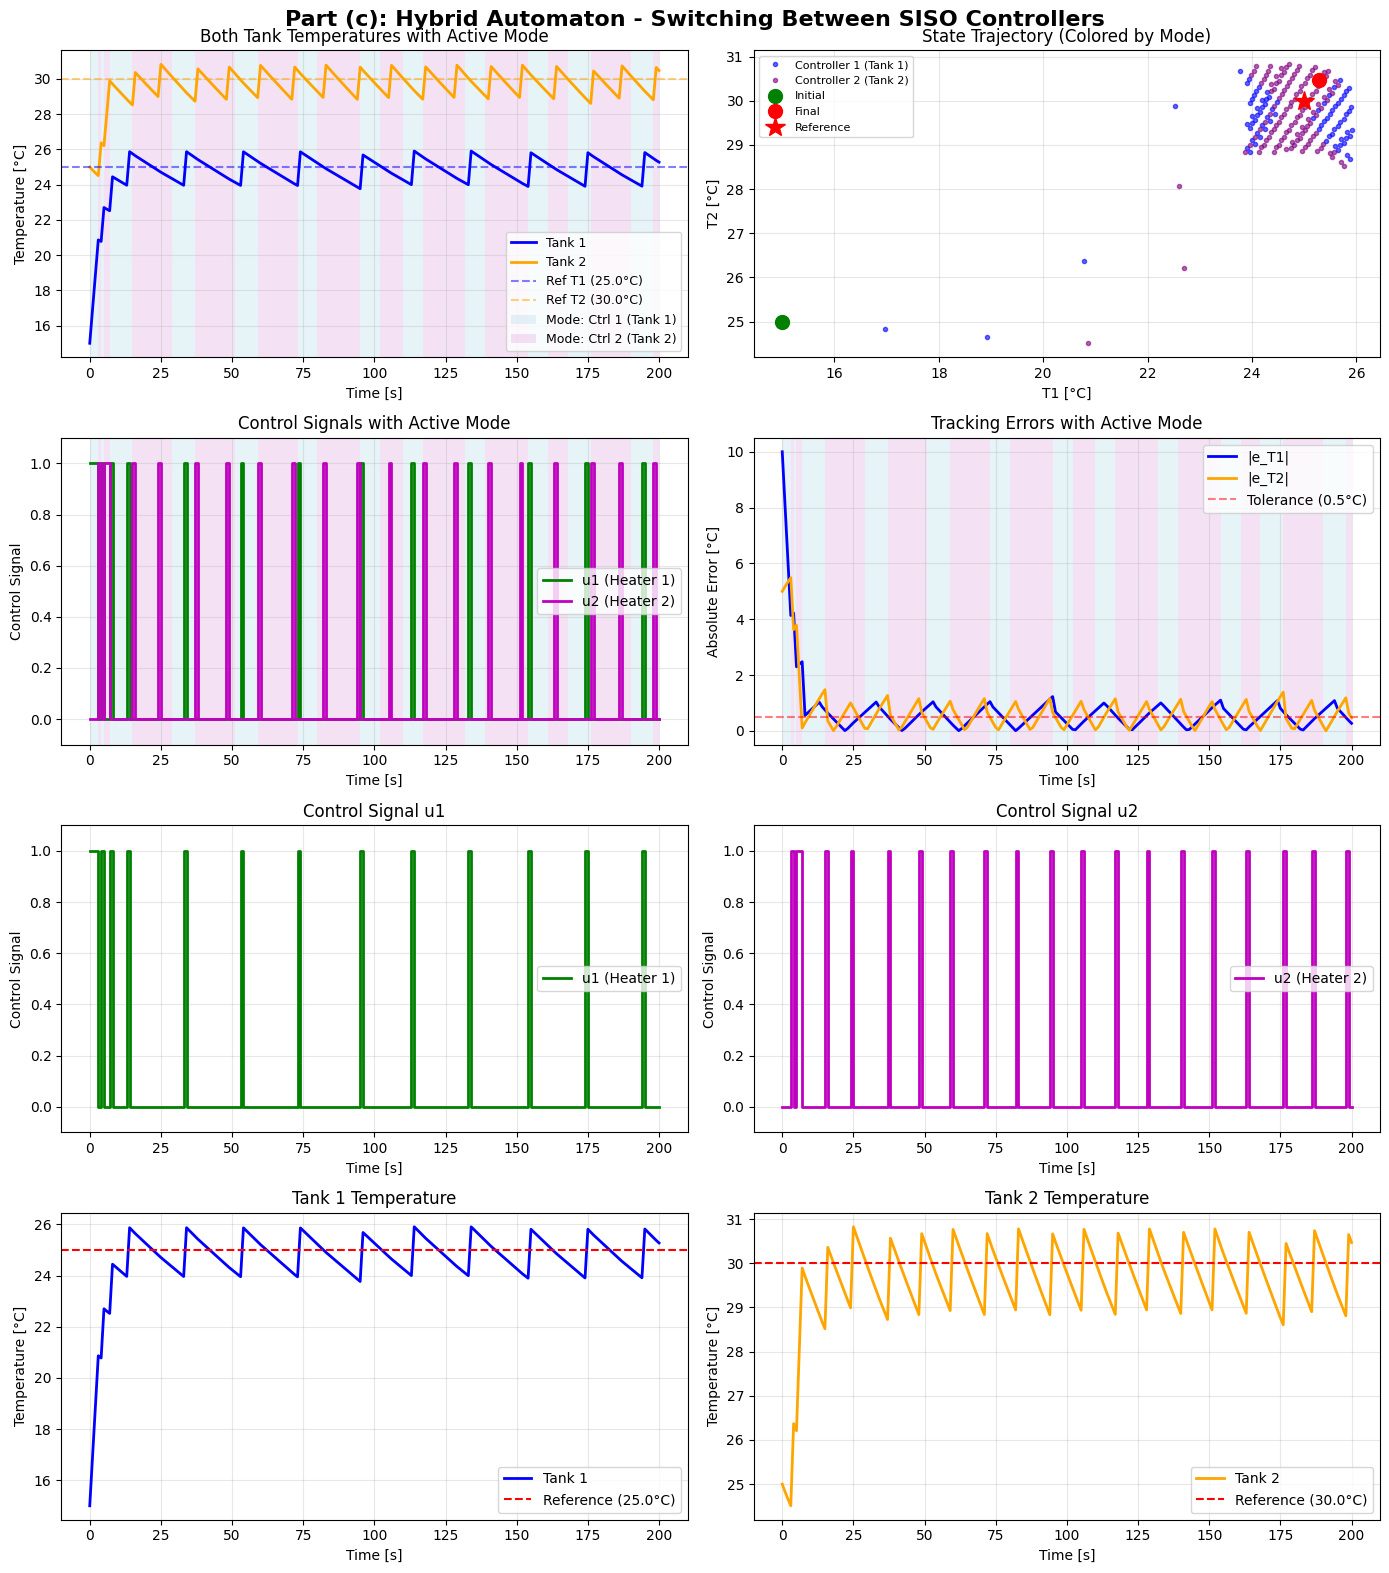

In [110]:
# Visualize hybrid automaton results
fig = plt.figure(figsize=(14, 16))
fig.suptitle('Part (c): Hybrid Automaton - Switching Between SISO Controllers', fontsize=16, fontweight='bold')

# Combined temperature trajectories with mode indication
ax1 = plt.subplot(4, 2, 1)
# Shade background by mode
for i in range(len(mode_traj_c)-1):
    color = 'lightblue' if mode_traj_c[i] == MODE_CTRL1 else 'plum'
    ax1.axvspan(T_time[i], T_time[i+1], facecolor=color, alpha=0.3)
# Plot temperatures
ax1.plot(T_time[:len(x_c)], x_c[:, 0], 'b-', linewidth=2, label='Tank 1')
ax1.plot(T_time[:len(x_c)], x_c[:, 1], 'orange', linewidth=2, label='Tank 2')
ax1.axhline(y=x_ref[0], color='b', linestyle='--', alpha=0.5, label=f'Ref T1 ({x_ref[0]}°C)')
ax1.axhline(y=x_ref[1], color='orange', linestyle='--', alpha=0.5, label=f'Ref T2 ({x_ref[1]}°C)')
# Add mode legend
from matplotlib.patches import Patch
legend_elements = ax1.get_legend_handles_labels()[0] + [
    Patch(facecolor='lightblue', alpha=0.3, label='Mode: Ctrl 1 (Tank 1)'),
    Patch(facecolor='plum', alpha=0.3, label='Mode: Ctrl 2 (Tank 2)')
]
ax1.legend(handles=legend_elements, fontsize=9, loc='best')
ax1.set_xlabel('Time [s]')
ax1.set_ylabel('Temperature [°C]')
ax1.set_title('Both Tank Temperatures with Active Mode')
ax1.grid(True, alpha=0.3)

# State space trajectory colored by mode
ax2 = plt.subplot(4, 2, 2)
for mode in [MODE_CTRL1, MODE_CTRL2]:
    mask = mode_traj_c == mode
    if np.any(mask):
        color = 'blue' if mode == MODE_CTRL1 else 'purple'
        ax2.plot(x_c[mask, 0], x_c[mask, 1], 'o', color=color, 
                markersize=3, alpha=0.6, label=mode_names_c[mode])
ax2.plot(x_c[0, 0], x_c[0, 1], 'go', markersize=10, label='Initial', zorder=5)
ax2.plot(x_c[-1, 0], x_c[-1, 1], 'ro', markersize=10, label='Final', zorder=5)
ax2.plot(x_ref[0], x_ref[1], 'r*', markersize=15, label='Reference', zorder=5)
ax2.set_xlabel('T1 [°C]')
ax2.set_ylabel('T2 [°C]')
ax2.set_title('State Trajectory (Colored by Mode)')
ax2.legend(fontsize=8, loc='best')
ax2.grid(True, alpha=0.3)

# Control signals (combined)
ax3 = plt.subplot(4, 2, 3)
# Shade background by mode
for i in range(len(mode_traj_c)-1):
    color = 'lightblue' if mode_traj_c[i] == MODE_CTRL1 else 'plum'
    ax3.axvspan(T_time[i], T_time[i+1], facecolor=color, alpha=0.3)
ax3.step(T_time[:len(u1_sim_c)], u1_sim_c, 'g-', linewidth=2, where='post', label='u1 (Heater 1)')
ax3.step(T_time[:len(u2_sim_c)], u2_sim_c, 'm-', linewidth=2, where='post', label='u2 (Heater 2)')
ax3.set_xlabel('Time [s]')
ax3.set_ylabel('Control Signal')
ax3.set_title('Control Signals with Active Mode')
ax3.set_ylim([-0.1, 1.1])
ax3.legend()
ax3.grid(True, alpha=0.3)

# Error trajectories
ax4 = plt.subplot(4, 2, 4)
# Shade background by mode
for i in range(len(mode_traj_c)-1):
    color = 'lightblue' if mode_traj_c[i] == MODE_CTRL1 else 'plum'
    ax4.axvspan(T_time[i], T_time[i+1], facecolor=color, alpha=0.3)
error_T1_traj = np.abs(x_c[:, 0] - x_ref[0])
error_T2_traj = np.abs(x_c[:, 1] - x_ref[1])
ax4.plot(T_time[:len(x_c)], error_T1_traj, 'b-', linewidth=2, label='|e_T1|')
ax4.plot(T_time[:len(x_c)], error_T2_traj, 'orange', linewidth=2, label='|e_T2|')
ax4.axhline(y=epsilon_switch, color='red', linestyle='--', alpha=0.5, label=f'Tolerance ({epsilon_switch}°C)')
ax4.set_xlabel('Time [s]')
ax4.set_ylabel('Absolute Error [°C]')
ax4.set_title('Tracking Errors with Active Mode')
ax4.legend()
ax4.grid(True, alpha=0.3)

# Individual control u1
ax5 = plt.subplot(4, 2, 5)
ax5.step(T_time[:len(u1_sim_c)], u1_sim_c, 'g-', linewidth=2, where='post', label='u1 (Heater 1)')
ax5.set_xlabel('Time [s]')
ax5.set_ylabel('Control Signal')
ax5.set_title('Control Signal u1')
ax5.set_ylim([-0.1, 1.1])
ax5.legend()
ax5.grid(True, alpha=0.3)

# Individual control u2
ax6 = plt.subplot(4, 2, 6)
ax6.step(T_time[:len(u2_sim_c)], u2_sim_c, 'm-', linewidth=2, where='post', label='u2 (Heater 2)')
ax6.set_xlabel('Time [s]')
ax6.set_ylabel('Control Signal')
ax6.set_title('Control Signal u2')
ax6.set_ylim([-0.1, 1.1])
ax6.legend()
ax6.grid(True, alpha=0.3)

# Individual temperature T1
ax7 = plt.subplot(4, 2, 7)
ax7.plot(T_time[:len(x_c)], x_c[:, 0], 'b-', linewidth=2, label='Tank 1')
ax7.axhline(y=x_ref[0], color='red', linestyle='--', label=f'Reference ({x_ref[0]}°C)')
ax7.set_xlabel('Time [s]')
ax7.set_ylabel('Temperature [°C]')
ax7.set_title('Tank 1 Temperature')
ax7.legend()
ax7.grid(True, alpha=0.3)

# Individual temperature T2
ax8 = plt.subplot(4, 2, 8)
ax8.plot(T_time[:len(x_c)], x_c[:, 1], 'orange', linewidth=2, label='Tank 2')
ax8.axhline(y=x_ref[1], color='red', linestyle='--', label=f'Reference ({x_ref[1]}°C)')
ax8.set_xlabel('Time [s]')
ax8.set_ylabel('Temperature [°C]')
ax8.set_title('Tank 2 Temperature')
ax8.legend()
ax8.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Multiple refereces

In [111]:
# Define time-varying reference targets
X_targets = [
    np.array([20.0, 25.0]),
    np.array([40.0, 30.0]),
    np.array([40.0, 30.0]),
    np.array([40.0, 30.0]),
    np.array([35.0, 35.0]),
    np.array([35.0, 35.0]),
    np.array([35.0, 35.0]),
    np.array([35.0, 35.0]),
    np.array([35.0, 35.0]),
]

# Create a function that returns the reference at each time step
def get_time_varying_ref(k):
    """Returns the reference for time step k, evenly distributed across targets."""
    n_targets = len(X_targets)
    steps_per_target = N // n_targets
    target_idx = min(k // steps_per_target, n_targets - 1)
    return X_targets[target_idx]

# Print reference schedule
steps_per_target = N // len(X_targets)
print("Reference schedule:")
for i, target in enumerate(X_targets):
    t_start = i * steps_per_target
    t_end = (i + 1) * steps_per_target - 1 if i < len(X_targets) - 1 else N - 1
    print(f"  t=[{t_start:3d}, {t_end:3d}]: T1={target[0]:.0f}°C, T2={target[1]:.0f}°C")

# Run simulation with time-varying references
print(f"\nStarting simulation with TIME-VARYING references...")
print(f"Initial state: T1={x0[0]:.2f}°C, T2={x0[1]:.2f}°C")

x_mv, u1_sim_mv, u2_sim_mv, mode_traj_mv, ref_traj_mv = simulate_ha_error_based(
    x0, get_time_varying_ref, epsilon_switch=epsilon_switch
)

# Count mode switches
mode_switches_mv = np.sum(mode_traj_mv[1:] != mode_traj_mv[:-1])

print(f"\nSimulation complete!")
print(f"Final state: T1={x_mv[-1,0]:.2f}°C, T2={x_mv[-1,1]:.2f}°C")
print(f"Final reference: T1={ref_traj_mv[-1,0]:.2f}°C, T2={ref_traj_mv[-1,1]:.2f}°C")
print(f"Final error: e1={x_mv[-1,0]-ref_traj_mv[-1,0]:.2f}°C, e2={x_mv[-1,1]-ref_traj_mv[-1,1]:.2f}°C")
print(f"Mode switches: {mode_switches_mv}")

Reference schedule:
  t=[  0,  21]: T1=20°C, T2=25°C
  t=[ 22,  43]: T1=40°C, T2=30°C
  t=[ 44,  65]: T1=40°C, T2=30°C
  t=[ 66,  87]: T1=40°C, T2=30°C
  t=[ 88, 109]: T1=35°C, T2=35°C
  t=[110, 131]: T1=35°C, T2=35°C
  t=[132, 153]: T1=35°C, T2=35°C
  t=[154, 175]: T1=35°C, T2=35°C
  t=[176, 200]: T1=35°C, T2=35°C

Starting simulation with TIME-VARYING references...
Initial state: T1=15.00°C, T2=25.00°C

Simulation complete!
Final state: T1=35.69°C, T2=34.35°C
Final reference: T1=35.00°C, T2=35.00°C
Final error: e1=0.69°C, e2=-0.65°C
Mode switches: 38


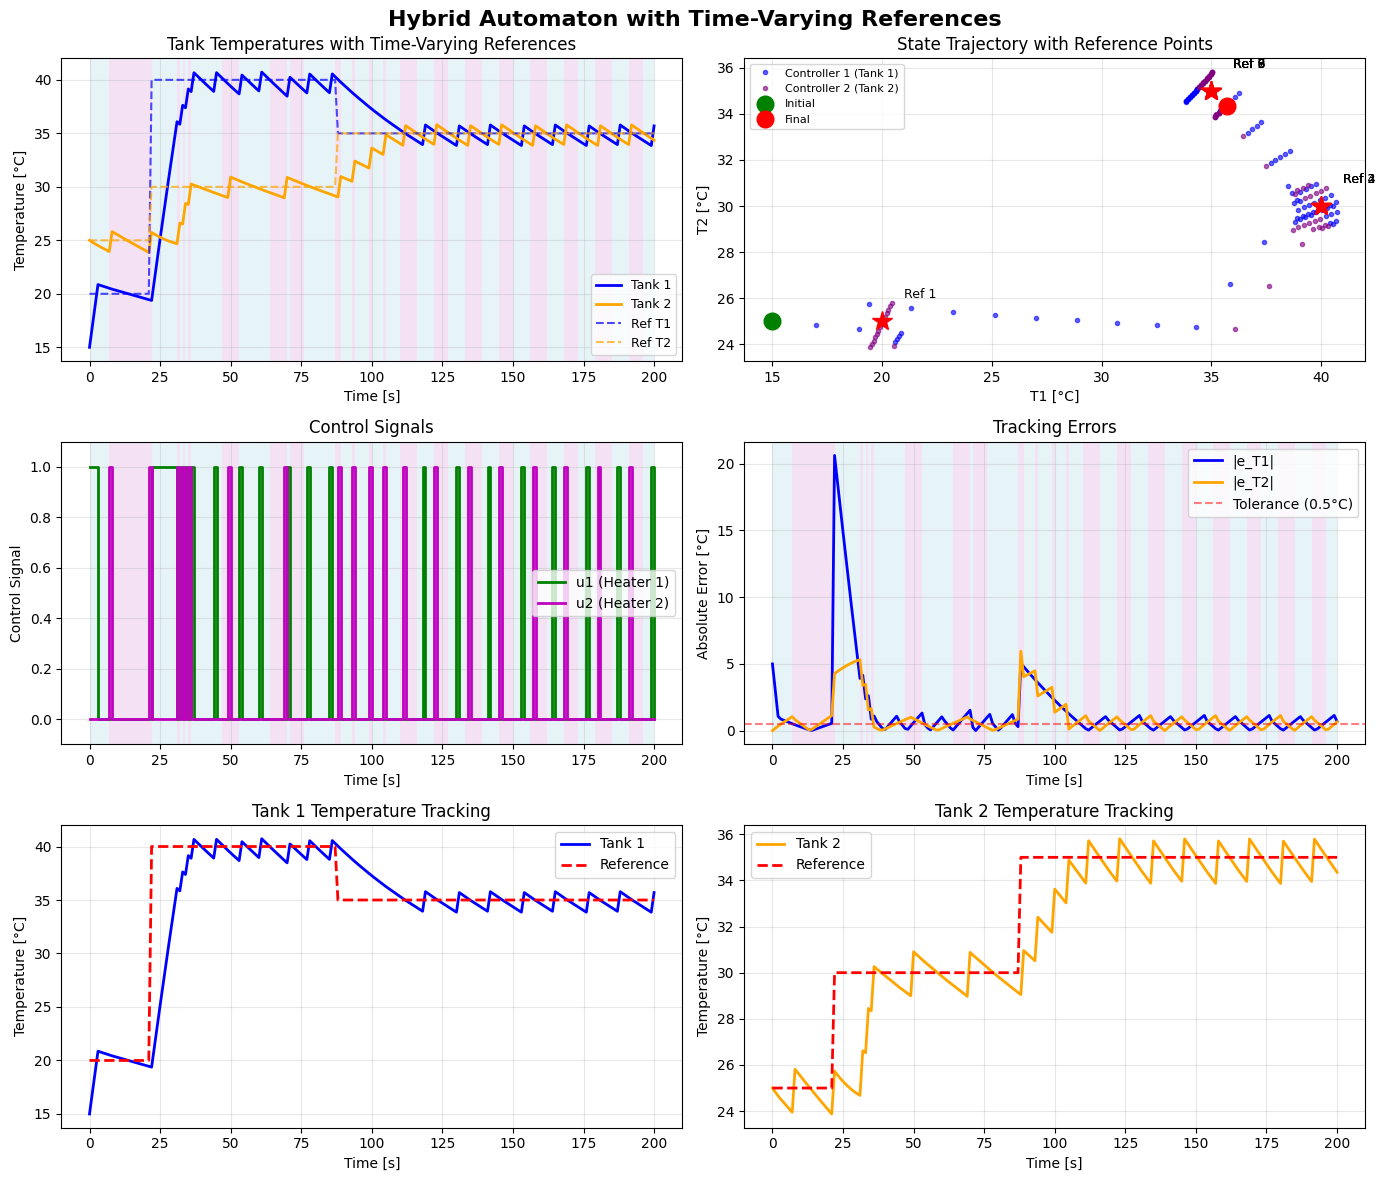

In [112]:
# Visualize multi-reference simulation results
fig = plt.figure(figsize=(14, 12))
fig.suptitle('Hybrid Automaton with Time-Varying References', fontsize=16, fontweight='bold')

# Temperature trajectories with time-varying references
ax1 = plt.subplot(3, 2, 1)
for i in range(len(mode_traj_mv)-1):
    color = 'lightblue' if mode_traj_mv[i] == MODE_CTRL1 else 'plum'
    ax1.axvspan(T_time[i], T_time[i+1], facecolor=color, alpha=0.3)
ax1.plot(T_time, x_mv[:, 0], 'b-', linewidth=2, label='Tank 1')
ax1.plot(T_time, x_mv[:, 1], 'orange', linewidth=2, label='Tank 2')
ax1.plot(T_time, ref_traj_mv[:, 0], 'b--', linewidth=1.5, alpha=0.7, label='Ref T1')
ax1.plot(T_time, ref_traj_mv[:, 1], 'orange', linestyle='--', linewidth=1.5, alpha=0.7, label='Ref T2')
ax1.set_xlabel('Time [s]')
ax1.set_ylabel('Temperature [°C]')
ax1.set_title('Tank Temperatures with Time-Varying References')
ax1.legend(fontsize=9)
ax1.grid(True, alpha=0.3)

# State space trajectory with reference points
ax2 = plt.subplot(3, 2, 2)
for mode in [MODE_CTRL1, MODE_CTRL2]:
    mask = mode_traj_mv == mode
    if np.any(mask):
        color = 'blue' if mode == MODE_CTRL1 else 'purple'
        ax2.plot(x_mv[mask, 0], x_mv[mask, 1], 'o', color=color, 
                markersize=3, alpha=0.6, label=mode_names_c[mode])
ax2.plot(x_mv[0, 0], x_mv[0, 1], 'go', markersize=12, label='Initial', zorder=5)
ax2.plot(x_mv[-1, 0], x_mv[-1, 1], 'ro', markersize=12, label='Final', zorder=5)
for i, target in enumerate(X_targets):
    ax2.plot(target[0], target[1], 'r*', markersize=15, zorder=5)
    ax2.annotate(f'Ref {i+1}', (target[0]+1, target[1]+1), fontsize=9)
ax2.set_xlabel('T1 [°C]')
ax2.set_ylabel('T2 [°C]')
ax2.set_title('State Trajectory with Reference Points')
ax2.legend(fontsize=8, loc='best')
ax2.grid(True, alpha=0.3)

# Control signals
ax3 = plt.subplot(3, 2, 3)
for i in range(len(mode_traj_mv)-1):
    color = 'lightblue' if mode_traj_mv[i] == MODE_CTRL1 else 'plum'
    ax3.axvspan(T_time[i], T_time[i+1], facecolor=color, alpha=0.3)
ax3.step(T_time, u1_sim_mv, 'g-', linewidth=2, where='post', label='u1 (Heater 1)')
ax3.step(T_time, u2_sim_mv, 'm-', linewidth=2, where='post', label='u2 (Heater 2)')
ax3.set_xlabel('Time [s]')
ax3.set_ylabel('Control Signal')
ax3.set_title('Control Signals')
ax3.set_ylim([-0.1, 1.1])
ax3.legend()
ax3.grid(True, alpha=0.3)

# Error trajectories (using time-varying reference)
ax4 = plt.subplot(3, 2, 4)
for i in range(len(mode_traj_mv)-1):
    color = 'lightblue' if mode_traj_mv[i] == MODE_CTRL1 else 'plum'
    ax4.axvspan(T_time[i], T_time[i+1], facecolor=color, alpha=0.3)
error_T1_mv = np.abs(x_mv[:, 0] - ref_traj_mv[:, 0])
error_T2_mv = np.abs(x_mv[:, 1] - ref_traj_mv[:, 1])
ax4.plot(T_time, error_T1_mv, 'b-', linewidth=2, label='|e_T1|')
ax4.plot(T_time, error_T2_mv, 'orange', linewidth=2, label='|e_T2|')
ax4.axhline(y=epsilon_switch, color='red', linestyle='--', alpha=0.5, label=f'Tolerance ({epsilon_switch}°C)')
ax4.set_xlabel('Time [s]')
ax4.set_ylabel('Absolute Error [°C]')
ax4.set_title('Tracking Errors')
ax4.legend()
ax4.grid(True, alpha=0.3)

# Tank 1 temperature with reference
ax5 = plt.subplot(3, 2, 5)
ax5.plot(T_time, x_mv[:, 0], 'b-', linewidth=2, label='Tank 1')
ax5.plot(T_time, ref_traj_mv[:, 0], 'r--', linewidth=2, label='Reference')
ax5.set_xlabel('Time [s]')
ax5.set_ylabel('Temperature [°C]')
ax5.set_title('Tank 1 Temperature Tracking')
ax5.legend()
ax5.grid(True, alpha=0.3)

# Tank 2 temperature with reference
ax6 = plt.subplot(3, 2, 6)
ax6.plot(T_time, x_mv[:, 1], 'orange', linewidth=2, label='Tank 2')
ax6.plot(T_time, ref_traj_mv[:, 1], 'r--', linewidth=2, label='Reference')
ax6.set_xlabel('Time [s]')
ax6.set_ylabel('Temperature [°C]')
ax6.set_title('Tank 2 Temperature Tracking')
ax6.legend()
ax6.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()